here we get the cordinants from input files

In [16]:
# Open input file
# infile = open('gr229.tsp', 'r')
infile = open('pr1002.tsp', 'r')

# # Read instance header for the gr229
# Name = infile.readline().strip().split()[1] # NAME
# FileType = infile.readline().strip().split()[1] # TYPE
# Comment = infile.readline().strip().split()[1] # COMMENT
# Dimension = infile.readline().strip().split()[1] # DIMENSION
# EdgeWeightType = infile.readline().strip().split()[1] # EDGE_WEIGHT_TYPE
# DIsplayDataType = infile.readline().strip().split()[1] # DISPLAY_DATA_TYPE
# infile.readline()

# Read instance header for the pr1002
Name = infile.readline().strip().split()[2] # NAME
Comment = infile.readline().strip().split()[2] # COMMENT
FileType = infile.readline().strip().split()[2] # TYPE
Dimension = infile.readline().strip().split()[2] # DIMENSION
EdgeWeightType = infile.readline().strip().split()[2] # EDGE_WEIGHT_TYPE
infile.readline()

# Read node list
nodelist = []
N = int(Dimension)
for i in range(N):
    x ,y = infile.readline().strip().split(' ')[1:]
    nodelist.append([float(x), float(y)])

# Close input file
infile.close()

In [17]:
import numpy as np
cor = np.array(nodelist)

In [18]:
from numba import njit
import math

this is the cost function which is calculeted by sum of Euclidean distance between the citiess

In [19]:
# @njit
def cost_function(data):
    fit = 0
    for i in range(len(data)-1):
        fit += math.sqrt((cor[data[i]][0] - cor[data[i+1]][0])**2 + (cor[data[i]][1] - cor[data[i+1]][1])**2)
    fit += math.sqrt((cor[data[0]][0] - cor[data[-1]][0])**2 + (cor[data[0]][1] - cor[data[-1]][1])**2)
    return fit

in this two function, we update phermons between each two city

In [20]:
# @njit
def pher_update(pher, data):
    for i in range(len(data)-1):
        cost = cost_function(data)
        pher[data[i]][data[i+1]] += 10/(cost*6)
        pher[data[i+1]][data[i]] = pher[data[i]][data[i+1]]
    pher[data[0]][data[-1]] += 10/(cost*6)
    pher[data[-1]][data[0]] = pher[data[0]][data[-1]]

In [21]:
def total_pher_update(pher):
    pher = 0.6*pher
    return pher

this function computes the probabity of city j to be chosen to travel next

In [22]:
@njit
def next_choice(pher, data, seen, i, j, alpha, beta, H):
    if (not H.any()):
        return 0
    if (seen[j] == 1):
        return 0
    div = sum((pher[i]**alpha)*(H**beta))
    return (pher[i][j]**alpha)*(H[j]**beta)/(div)

this is the heuristic function which is based of a distance between two cities

In [23]:
@njit
def heu(seen, i):
    h = np.zeros(len(seen))
    if (seen.sum() == N):
        return h
    for j in range(len(seen)):
        if (seen[j]==0 and i!=j):
            h[j] = 1/(math.sqrt((cor[i][0] - cor[j][0])**2 + (cor[i][1] - cor[j][1])**2))
    return h

this is the main algorithm:
>part A:
in this part, we run the ant colony algorithm for gen_num times

>part B:
start all the ants from random city

>part C:
choose the $j^{th}$ city for each ant

>part D:
in this part we calculate the probability of choosing a subsets for all of them

>part E:
then we choose a subsets by the random number from random place

>part F:
at the end of generation, some of the phermons get disappeared

>part G:
then we find the best ant in each generation

In [24]:
def algorithm(a, b, ant_num, gen_num):
    alpha = a
    beta = b    
    
    phero = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            phero[i] = 0.5
            
    paths = []
    best = []
    
    for i in range(gen_num): #part A

        S = np.zeros((ant_num, N), dtype=int) #is city added or not
        cities = np.zeros((ant_num, N), dtype=int) #order of visiting cities
        
        ran = np.random.randint(N)
        for j in range(ant_num): #part B
            S[j][ran] = 1
            cities[j][0] = ran
        
        for j in range(1, N):

            for k in range(ant_num): #part C
                p_choose = np.zeros(N)
                H = heu(S[k], cities[k][j-1])
                
                for p in range(N): #part D
                    p_choose[p] = next_choice(phero, cities[k], S[k], cities[k][j-1], p, alpha, beta, H)

                    
                rnd_num = np.random.rand(1)
                b = np.random.randint(N)

                su = 0
                s = -1
                while(su < rnd_num): #part E
                    s += 1
                    if (s >= N):
                        s -= 1
                        break
                    su += p_choose[(s+b)%N]
                cities[k][j] = (s+b)%N
                S[k][(s+b)%N] = 1
                
        for j in range(ant_num): #part F
            pher_update(phero, cities[j])
        phero = total_pher_update(phero)
            
        b = np.inf
        p = []
        for j in range(ant_num): #part G
            if (cost_function(cities[j]) < b):
                b = cost_function(cities[j])
                p = cities[j]
        paths.append(p)
        best.append(b)
        print(b)
    return paths, best

In [12]:
import matplotlib.pyplot as plt

In [10]:
path, best = algorithm(1, 20, 1000, 5) #data = gr229

1981.0035442710846
1896.3954733430048
1957.7306583359275
1850.9575369946544
2009.87034169255


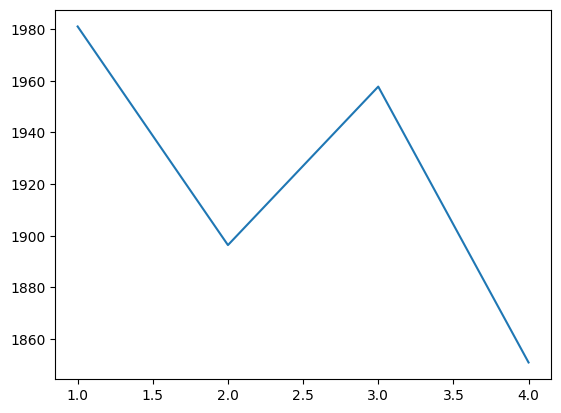

In [15]:
plt.plot([i+1 for i in range(4)], best[:4])
plt.show()

In [27]:
path, best = algorithm(1, 20, 10, 1) #data = pr1002

319419.67887563974


In [30]:
path, best = algorithm(1, 20, 5, 1) #data = pr1002

314903.45723707374


In [32]:
path, best = algorithm(1, 20, 5, 10) #data = pr1002

315406.6610139918
327650.26971145195
312440.9148086867
325665.0287294101
323153.62206449296
323711.65925960144
325565.735233356
319479.8989941807
324001.9206309662
321054.67739076226


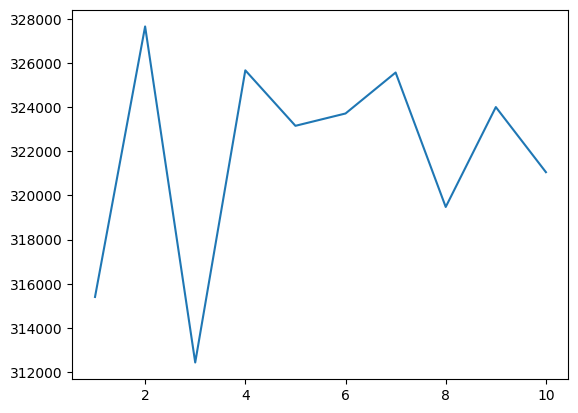

In [34]:
plt.plot([i+1 for i in range(10)], best)
plt.show()

so the algorithm works pretty well for both test cases

gr229 = 1850

pr1002 = 312440